東京工業大学2021年度　実践AI・データサイエンス
# 金融とデータサイエンス
2021/7/9 (金)　16:15-17:55
## 三菱UFJ銀行　森本 裕介

## 自己紹介

 - 学生時代は数学を専攻 (東工大 学士, 東大 修士/博士)
 - 2009年三菱UFJ銀行入社
     - 入社して以来ずっとクオンツ業務(金融機関で数理科学やITを駆使する仕事)を担当
     - 2020年までデリバティブのプライシングモデル開発担当(金利モデル、XVA)
         - 日本銀行金融研究所出向(2011-2012)
         - MorganStanley, NY出向(2019-2021)
     - 2021年から為替のアルゴリズム取引(EFX)を担当
     
 - デリバティブ開発とEFX開発の違い(私見)
   
|   | デリバティブモデル開発 | EFXモデル開発 | 
| :--- | :--- | :---| 
|時間スケール| 日次データ<br>１取引期間は1年から数十年 <br> １つのモデルを数ヶ月〜１、２年で開発| ミリ秒データ<br>１取引のライフタイムは数秒から数十秒<br> １つのモデルを数週間〜１、２ヶ月で開発| 
|数理スキル| 数理ファイナンス<br>確率解析を中心とした純粋数学<br>応用数学 |データベース<br>統計分析<br>機械学習|
|プログラミング| 複雑な数式を精緻に計算<br>重たい計算を高速に(数秒くらいで)計算<br>C++(Rust ?), C#, Python| marketの仕組みや<br>人間のトレーディングなどをアルゴリズム化<br>シンプルなロジックを高速に(一瞬で)計算<br>Java, Python|

## 本講義の目的
- 為替予測を体験し、金融実務に使われているデータサイエンスを理解すること。

## スケジュール
- 前半は為替の変動の特徴量の分析
- 後半はいくつかの特徴量を用いた為替予測と取引戦略手法の紹介

# 動作環境

- Python　3.8.5　Anaconda
     https://www.anaconda.com/products/individual
- pandas-datareader
     https://pandas-datareader.readthedocs.io/en/latest/index.html

# Contents
## 1. 為替はなぜ動くのか
- 1.1. 為替の定義
- 1.2. データの取得
- 1.3. ファンダメンタル分析
- 1.4. テクニカルチャート分析
- 1.5. Random Walk 仮説

## 2. 為替を予測してみよう
- 2.1. なぜ予測するのか
- 2.2. 金融実務での予測手法
- 2.3. 予測手法の例
- 2.4. 取引戦略のモデル化とバックテスト


# 1. 為替はなぜ動くのか

## 1.1 為替の定義
- 外国為替(Foreign Exchange, Forex, FX)
    - 通貨１と通貨２を交換するときの交換レート
    - 表示方法：　通貨1通貨２ = 「通貨1の１単位がが通貨2でいくらか」 
        - USDJPY 109.38 $\Leftrightarrow$ １ドル109.38円
        - EURUSD 1.21  $\Leftrightarrow$ 1EUR 1.21 ドル $\Leftrightarrow$ 1 EUR 1.21 * 109.38 = 132.35 円 
        - すなわちEURJPY 132.35
    - 為替は24時間休みなく取引が行われており、常に変動している。
        - ### 為替はなぜ動くのか？ すなわち   <span style="color: red; ">為替変動の特徴量は何か？

## 1.2 データ取得
- 今回の分析はFredというサイトからフリーで取得できる日次の経済データを利用する。
- pandas_datareader という pythonのライブラリを使って、データをダウンロードする。
- 欲しいデータのラベル名はFredのサイトhttps://fred.stlouisfed.org/categories/　から検索できる。

<AxesSubplot:xlabel='DATE'>

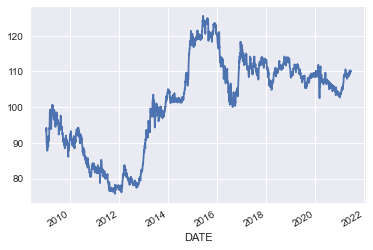

In [1]:
# Prepare all Economic data
import pandas as pd
from pylab import mpl, plt
import pandas_datareader.data as web
plt.style.use('seaborn')
%matplotlib inline

start='2009/1/1'
end = '2021/06/20'

df = pd.DataFrame({
    'fx_usdjpy': web.DataReader('DEXJPUS', 'fred', start, end)['DEXJPUS'],
    'fx_eurusd': web.DataReader('DEXUSEU', 'fred', start, end)['DEXUSEU'],
    'fx_gbpusd': web.DataReader('DEXUSUK', 'fred', start, end)['DEXUSUK'],
    'fx_audusd': web.DataReader('DEXUSAL', 'fred', start, end)['DEXUSAL'],
    'fx_nzdusd': web.DataReader('DEXUSNZ', 'fred', start, end)['DEXUSNZ'],
    'ir_jpy': web.DataReader('JPY6MTD156N','fred', start,end)['JPY6MTD156N'],
    'ir_usd': web.DataReader('DGS10','fred',start, end)['DGS10'],
    'oil': web.DataReader('DCOILBRENTEU', 'fred', start,end)['DCOILBRENTEU'],
    'stock_us':web.DataReader("NASDAQ100", 'fred', start,end)['NASDAQ100'],
    'stock_jp':web.DataReader("NIKKEI225","fred",start,end)['NIKKEI225']
    })
df.dropna(inplace=True)

df['fx_usdjpy'].plot()

## 1.３データの前処理
- 1. 価格データから価格変化のデータへの変換
    - 価格データのような時系列データは定常的でない。過去の長期間の水準の履歴に依存している。
    - 一方、多くの統計モデルは時間定常的なデータを必要としている。
        - 例えば、教師あり学習では特徴量とラベル(正解)データ$(X, y)$に対し、時間に依存しない対応関係 $y = F(X)$を推測。
    - 差分を取ることで、過去に蓄積された履歴を取り除いて、定常データに変換出来る。
    - 価格データに対しては、対数収益率を用いることが多い。
     $$\text{対数収益率}=\log {X_{t_i}}-\log{X_{t_{i-1}}}.$$
    - 金利データは負になる事もあることに注意
        - $\log$が取れない。金利には普通の差分を用いる。
        $$\text{差分}=X_{t_{i}}-X_{t_{i-1}}.$$
        - 金利は$\log${債券価格}のように見做せるので、金利の差分は債券価格の対数収益率に対応しており整合がとれている。

- 2. 学習用データとテストデータの分離
    - 全データの80％を学習用に、20%をテスト用に分離しておく。

- 3. データの正規化
    - 学習用データの平均が0、標準偏差が１になるように変換し、アセットの違いによるスケールの違いを取り除く。
        - スケール変換に使う平均、標準偏差は学習用データのみから計算することに注意 !
        - テストデータまで込めて計算してしまうと、学習時にテストのデータをカンニングしていることになってしまう
$$\tilde{X}_{train} = \frac{X_{train}-\mu_{train}}{\sigma_{train}}, \\ 
\tilde{X}_{test} = \frac{X_{test}-\mu_{train}}{\sigma_{train}}. $$

  

In [3]:
# Data preprocessing
import numpy as np
from sklearn.model_selection import train_test_split

# 価格データを対数変化データに変換
df['return_usdjpy'] = np.log(df['fx_usdjpy']).diff()
df['return_eurusd'] = np.log(df['fx_eurusd']).diff()
df['return_gbpusd'] = np.log(df['fx_gbpusd']).diff()
df['return_audusd'] = np.log(df['fx_audusd']).diff()
df['return_nzdusd'] = np.log(df['fx_nzdusd']).diff()
df['return_oil'] = np.log(df['oil']).diff()
df['return_stock_us'] = np.log(df['stock_us']).diff()
df['return_stock_jp'] = np.log(df['stock_jp']).diff()
df['return_ir_jpy'] = df['ir_jpy'].diff()
df['return_ir_usd'] = df['ir_usd'].diff()

# Lag付きのデータの用意(過去3日間分のシフトされたデータ)
lags = 3
for name in df.columns:
    for lag in range(1, lags + 1):
        df['{}_lag{}'.format(name, lag)] = df[name].shift(lag)
df.dropna(inplace=True)

# dataをTraining dataとTest dataに分離しておく
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
#Training用データから統計量を取得
scalar.fit(df_train) 

# Trainig dataを自分の統計量を使って、平均0, 標準偏差1になるようにスケーリング
df_train_std = pd.DataFrame(scalar.transform(df_train), columns=df.columns)
# Test data はTrainig dataと同じパラメータでスケーリング
df_test_std = pd.DataFrame(scalar.transform(df_test), columns=df.columns)

df_train_std.head()

,fx_usdjpy,fx_eurusd,fx_gbpusd,fx_audusd,fx_nzdusd,ir_jpy,ir_usd,oil,stock_us,stock_jp,...,return_ir_jpy_lag3_lag3,return_ir_usd_lag1_lag1,return_ir_usd_lag1_lag2,return_ir_usd_lag1_lag3,return_ir_usd_lag2_lag1,return_ir_usd_lag2_lag2,return_ir_usd_lag2_lag3,return_ir_usd_lag3_lag1,return_ir_usd_lag3_lag2,return_ir_usd_lag3_lag3
0,-0.715969,0.430163,-0.331665,-1.749164,-2.897910,3.206735,-0.471941,-1.404827,-1.497085,-1.349610,...,-3.486307,-1.774758,-0.712371,-0.889134,-0.712371,-0.889134,0.172758,-0.889134,0.172758,0.349514
1,-0.665955,0.557024,-0.228195,-1.664929,-2.747263,3.194409,-0.255673,-1.363315,-1.488374,-1.306779,...,-1.215884,-1.597729,-1.774458,-0.712139,-1.774458,-0.712139,-0.889205,-0.712139,-0.889205,0.172523
2,-0.673100,0.304994,-0.775438,-1.735951,-2.941735,3.188247,-0.189128,-1.446340,-1.525036,-1.340813,...,-1.669969,-0.181497,-1.597443,-1.774109,-1.597443,-1.774109,-0.712211,-1.774109,-0.712211,-0.889419
3,-0.843861,0.240717,-1.001539,-1.801192,-3.021167,3.188247,0.077049,-1.496155,-1.495751,-1.374804,...,-1.215884,2.296909,-0.181328,-1.597114,-0.181328,-1.597114,-1.774174,-1.597114,-1.774174,-0.712429
4,-0.783845,0.312605,-0.915697,-1.760726,-2.952691,3.157433,0.176865,-1.401053,-1.506285,-1.343723,...,-4.619702,0.703648,2.296874,-0.181154,2.296874,-0.181154,-1.597181,-0.181154,-1.597181,-1.774371


1. 為替はなぜ動くのか

## 為替を動かす要素
- 基本的には需給で決まっているはず
    - ドルが欲しい人が多ければドルの価値は円に対して上がるので、USD JPYの交換レートは上がる
- では何が需給を動かす要因になるのか？

## 為替を動かす要素の例 1. 金利差

|通貨| 金利 |現在| 1年後|
|:---  | :--- | :--- | :--- |
|USD| 5% | 1ドル | 1.05 ドル|
|JPY| 0.1% | 100円| 101 円|

- ドルで預金していると1年後 1.05倍になるのに、円で預金していると1.001倍にしかならない。
- 円を借りて来てドルを購入するともうかる確率が高い。
- よって金利差が大きくなると、金利が高い通貨が買われ、安い通貨が売られる傾向がある。

<AxesSubplot:xlabel='ir_usd_jpy', ylabel='return_usdjpy'>

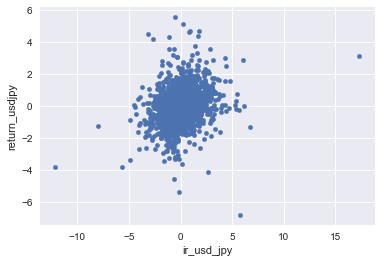

In [3]:
#correlation 金利差、USDJPY
df_train_std['ir_usd_jpy'] =df_train_std['return_ir_usd'] - df_train_std['return_ir_jpy'] 
df_train_std.plot.scatter(x='ir_usd_jpy', y='return_usdjpy')

## 為替を動かす要素の例2 相関
- ニュージーランド経済はオーストラリア経済に左右される
    - AUDUSDが上がるとNZDUSDも上がる
- 資源国において、石油などは財源の中心
    - 石油価格が上がるとAUDUSDも上がる

<AxesSubplot:xlabel='return_audusd', ylabel='return_nzdusd'>

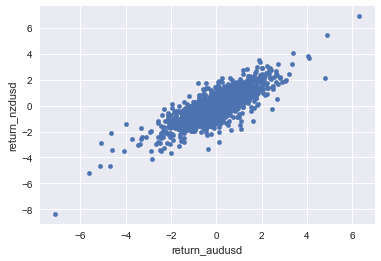

In [4]:
# correlation AUD & NZD
df_train_std.plot.scatter(x='return_audusd', y='return_nzdusd')

<AxesSubplot:xlabel='return_oil', ylabel='return_audusd'>

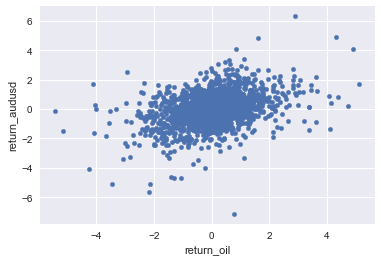

In [5]:
# correlation AUD & OIL
df_train_std.plot.scatter(x='return_oil', y='return_audusd')

## 1.4. 為替はなぜ動くのか：テクニカル分析
### 単純移動平均　(simple moving average, sma)
長期SMAと短期SMAがクロスするところが売買のサイン
- 短気SMA > 長期SMA => 買い(ロング)ポジション
- 短気SMA < 長期SMA => 売り(ショート)ポジション
      

<AxesSubplot:xlabel='DATE'>

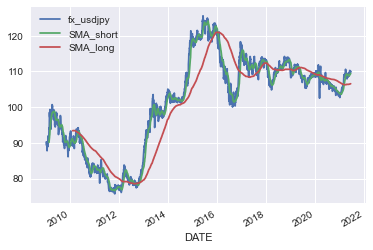

In [6]:
sma_short = 25
sma_long = 250

data = pd.DataFrame({
    'fx_usdjpy': df['fx_usdjpy'],
    'SMA_short': df['fx_usdjpy'].rolling(sma_short).mean(),
    'SMA_long': df['fx_usdjpy'].rolling(sma_long).mean()
})
data.plot()

## 1.5. 為替はなぜ動くのか：Random Walk仮説

- 効率的市場仮説
    - 入手可能な情報は全て現在の価格に反映されおり、将来の価格変動は完全にRandomという仮説。
    - これが正しいとすると、どんなアルゴリズムでも市場平均に勝てないということだが、科学的には証明されていない。
    - USDJPYの対数収益率のヒストグラムを見ると、確かに正規分布に近い形だが、完全にそうというわけではない。

2300


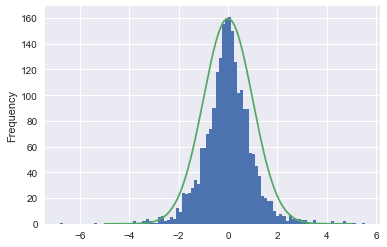

In [7]:
#histgram of log return
from scipy.stats import norm

df_train_std['return_usdjpy'].plot.hist(bins=100)
x=np.linspace(-5,5,1000)
plt.plot(x, norm.pdf(x)*400)
print(df_train_std['return_usdjpy'].count())

# 2. 為替を予測してみよう

## 2.1. なぜ予測するのか
### 外国為替市場の安定化、健全な市場機能の維持、向上
- 三菱UFJ銀行は本邦を代表する市場参加者として、市場に流動性を供給し、市場を安定化させる社会的役割を有す


## 2.2. 為替相場の歴史
|   |  | ~2000  |  2000~2015 | 2015~|
| :--- | :---: | :---| :---| :---|
|| プライシング | 人間 | 人間/機械  | 人間/機械  |
|| 予測 | 人間 |人間 | 人間/機械 |
|| 予測手法 |  | 人間による分析、<br>経験、勘 <br>初歩的な統計分析| 人間/機械 <br> 機械学習、DeepLearning |

- プライシング：　顧客に適切にプライスを提示すること。
- たとえば顧客からドル円を取引したいという申し出があれば、「買うなら105.20円(Bid)、売るなら105.21円(Ask)」などと表示


## 2.3 金融実務での予測手法
- 1. Output を決める
    - 時間軸
        - 実務ではミリ秒単位のティックデータから、数秒後の為替を予測している
        - 今回は日次のデータから、次の日の為替を予測してみる
    - 回帰、分類
        - 為替の値動きを予想するのか(回帰)
        - 為替の値動きの符合(Up/Down)のみを予測するのか（分類）=> 今回はこちらを実施
- 2. Input を決める
    - 予想のアイディア（ストーリー）から入力データを収集
    - 前処理を施して特徴量を抽出
- 3. さまざまな手法で分析、予測モデルを開発し、PDCAを高速で回す
 

|入力| 手法 | 出力|評価|
| :--- | :---: | :---|:---|
|金利<br> ニュース<br>需要<br>他アセット(株など) | 線形回帰(単回帰、重回帰)<br>ロジスティック回帰<br>Lasso<br>RandomForest<br>SVM<br>Neural Networkなど |時間軸<br>回帰、分類結果 | 結果分析|


- InSample期間でTrainingおよび、ハイパーパラメータの決定を行い、テスト期間でテストを行う。

|2011/1/1~2018/11/30|2018/12/1~2021/6/20|
| :---: | :---:| 
| [------------------------------ In Sample -------------------------------] |[---- Out of Sample ----]|
| Training 及び Validation | Test   |



## 2.3.1 予測モデルの例１. 線形回帰

- この１０数年間にもよく使われてきた単純なモデル
- 目的変数と説明変数の組 $(y, X)={(y_{\ell}, \{X^{(k)}_{\ell}\}_{k=1}^K)}_{\ell=1}^L$ に対し、目的変数を説明変数の線形関数で表現する
    - $K: $説明変数の数
    - $L$: データのsample数
$$　u = w_0+\sum_{k=1}^K w_k X^{(k)},$$


- Loss 関数であるMSE（mean square error）
$$Loss(w)=\frac{1}{L}\sum_{\ell=1}^L |y_{\ell}-u_{\ell} |^2$$
を最小化するようにパラメータ $w$ を決める(最小二乗法)。


## 2.3.1(1)　予測モデルの例 線形回帰(1)

### Setting
- Output
     - 為替の上下予想(上昇=>＋1、下落=> -1)

- Input 
    - 過去３日間のFX_USDJPYの対数収益率
    
### Result
     - 学習データでは51％の正解率だが、テストデータでは46％程の正解率

,Training,Test
score,0.516522,0.462609


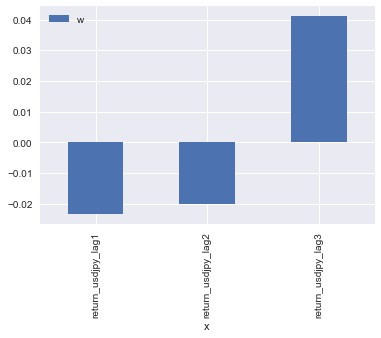

In [8]:
# regression(1)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# 特徴量
attribute = ['return_usdjpy_lag1', 'return_usdjpy_lag2', 'return_usdjpy_lag3']
# Input
X_train = df_train_std[attribute]
X_test = df_test_std[attribute]

# 正解データ
y_train = np.sign(df_train_std['return_usdjpy'])
y_test = np.sign(df_test_std['return_usdjpy'])

# model
regression = LinearRegression()
# Training
regression.fit(X_train, y_train)

# 回帰係数 w
coeff = pd.DataFrame({'x': X_train.columns, 'w': regression.coef_})
coeff.set_index('x').plot.bar()

# Output: 為替予想 up(+1) down(-1)
predict_regression_train = np.sign(regression.predict(X_train))
predict_regression_test = np.sign(regression.predict(X_test))

# Trainig/Test それぞれ正解に対して何割正解したか。
pd.DataFrame({
    'Training': [metrics.accuracy_score(predict_regression_train, y_train)],
    'Test':[metrics.accuracy_score(predict_regression_test, y_test)] }, index={'score'})


## 2.3.1(2) 予測モデルの例 線形回帰(2)
説明変数を増やしてみる
### Setting　

- Output
     - 為替の上下予想(上昇=>＋1、下落=> -1)

- Input 
    - 直近3日間のFX_USDJPYの対数収益率
    - 直近3日間のFX_EURUSDの対数収益率
    - 直近3日間のFX_GBPUSDの対数収益率
    - 直近3日間のFX_AUDUSDの対数収益率
    - 直近3日間のFX_OILの対数収益率
    - 直近3日間のIR_USDの差分
    - 直近3日間のIR_JPYの差分
    - 直近3日間のUSD株（ダウ）の対数収益率
    - 直近3日間の日本株（日経平均）の対数収益率



### Result
    - 学習データでのパフォーマンスは上がってるものの、テストデータに対する正解率は向上していない
        - パラメータが過剰になり、オーバーフィッティングが起こっている

,Training,Test
score,0.55913,0.497391


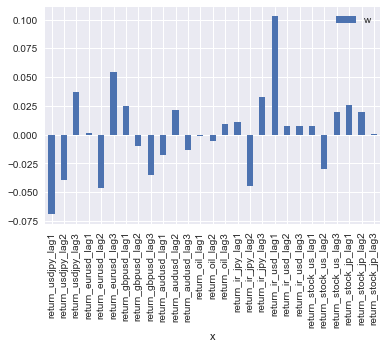

In [9]:
# regression(2)

# 特徴量
attribute = [
'return_usdjpy_lag1', 'return_usdjpy_lag2', 'return_usdjpy_lag3',
'return_eurusd_lag1', 'return_eurusd_lag2', 'return_eurusd_lag3',
'return_gbpusd_lag1','return_gbpusd_lag2','return_gbpusd_lag3',
'return_audusd_lag1','return_audusd_lag2','return_audusd_lag3',
'return_oil_lag1','return_oil_lag2','return_oil_lag3',
'return_ir_jpy_lag1','return_ir_jpy_lag2','return_ir_jpy_lag3',
'return_ir_usd_lag1','return_ir_usd_lag2','return_ir_usd_lag3',
'return_stock_us_lag1','return_stock_us_lag2','return_stock_us_lag3',
'return_stock_jp_lag1','return_stock_jp_lag2', 'return_stock_jp_lag3']

# Input
X_train = df_train_std[attribute]
X_test = df_test_std[attribute]

regression2= LinearRegression() # model
regression2.fit(X_train, y_train) # Training

# 回帰係数 w
coeff = pd.DataFrame({'x': X_train.columns, 'w': regression2.coef_})
coeff.set_index('x').plot.bar()

# Output: 為替予想 up(+1) down(-1)
predict_regression2_train = np.sign(regression2.predict(X_train))
predict_regression2_test = np.sign(regression2.predict(X_test))

pd.DataFrame({
    'Training': [metrics.accuracy_score(predict_regression2_train, y_train)],
    'Test':[metrics.accuracy_score(predict_regression2_test, y_test)] }, index={'score'})

## 2.3.2 予測モデルの例 LASSO回帰

- 線形回帰のLoss関数に正則化項 $R(w)$を付け加えたもの
$$Loss(a)=\frac{1}{L}\sum_{\ell=1}^L |y_{\ell}-u_{\ell} |^2+\alpha R(w),$$
ここで、$\alpha$は正則化の強さを調整するhyper parameter。
- 正則化項
     - $L^1$-norm: Lasso回帰 $$R(w)=\|w\|_1=\sum_{k=1}^K |w_k|.$$
     - $L^2$-norm: Ridge回帰 $$R(w)=\|w\|_2=\sqrt{\sum_{k=1}^K |w_k|^2}.$$
- 通常$L^2$-normの方が数学的な性質は良い（絶対値より２乗の方が滑らかで微分などの計算がしやすい）が、回帰の正則化に関しては$L^1$-normを用いた方が$w$の要素が0になりやすいというメリットがある（スパース性）。
- すなわち重要な特徴量を自動で選択してくれる。
    - 一般的には選択された特徴量を確認し、解釈可能なら採用するという使い方をする。
    - 裏側のストーリーを想像できるかどうか。
    - 何か分からないけど使ってしまうのは、うまくいっている時は問題ないが、うまくいかなくなった時に評価や説明ができないので、使いにくい。


## 2.3.2 予測モデルの例 LASSO回帰

### Setting
- Input/Output: 2.3.1(2)と同じ


- $\alpha=0.01$

### Result

- 学習データに対する正解率は少し下がるが、テストデータに対する正解率は改善する。
- Oil, FX_GBPUSD, FX_AUDUSD, 日本株、米株は余り重要でないことが示唆された。


,Training,Test
score,0.556087,0.518261


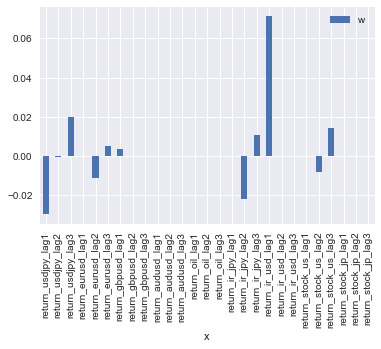

In [10]:
# Lasso
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.02) # model
lasso.fit(X_train, y_train) # Training

coeff = pd.DataFrame({'x': X_train.columns, 'w': lasso.coef_}) # 回帰係数
coeff.set_index('x').plot.bar()

# Output: 為替予想 up(+1) down(-1)
predict_lasso_train = np.sign(lasso.predict(X_train))
predict_lasso_test = np.sign(lasso.predict(X_test))

pd.DataFrame({
    'Training': [metrics.accuracy_score(predict_lasso_train, y_train)], #Traing dataに対する正解率
    'Test':[metrics.accuracy_score(predict_lasso_test, y_test)] }, # Test dataに対する正解率
    index={'score'})

## 2.3.3 予測モデルの例 Decision Tree /  Random Forest
### Decision Tree
- 条件分岐の結合によって FXUSDJPYが上がるか下がるか予想する。
- 特徴量の数や分岐の深さが少ない場合は処理結果が解釈しやすく、妥当性を判断しやすいという利点がある。
- Trainingデータにオーバーフィッティングしやすいのが弱点

||  特徴量１||
| :----| :----: |:---- | 
||  FX_USDJPYの直前の対数収益率> 0||
|True||False|

||  特徴量2|||  特徴量2||
| :----| :----: |:---- | :----| :----: |:---- | 
||  FX_EURUSDの直前の対数収益率 > 5%||  FX_EURUSDの直前の対数収益率 > 10%||
|True||False|True||False|
|Up||Down|Up||Down|

### Random Forest
- Decision Treeを幾つかRandomに構成し、それを組み合わせるアンサンブル学習。
- 少しづつ異なるDecision Treeをたくさん集めることでその結果の平均をとる。
- Decision Treeの最大の弱点であるオーバーフィットオーバーフィットの度合いを減らす。

## Hyper Parameter の決定
- 全てIn Sampleのデータで行う。学習及びパラメータの学習はテスト期間(Out of Sample)のデータに一切触れないこと。
    - Hyper Parameter（学習の前に事前に与えておくパラメータ）の決定にはGridSearchなどを用いる.
        - 全ての候補の組み合わせに対して、CrossValidationを実行し、もっとも評価の高いものを採用する。
    - 今回は５分割のCrossValidationを行う
        - データを５分割し、そのうち４つ（80％）を学習に使用し、残り１つ(20%)を得られたparameterのValidationに使う。
        - In Sampleのデータを使って5つのケースでテストできる。評価は5回の平均を用いる。
        
||||In Sample|||
| :--- | :--- | :---: | :---| :----|:---|
|(case1)|sample1|sample2 |sample3|sample4|<span style="color: red; ">sample5<span style="color: red; ">|
|(case2)|sample1|sample2 |sample3|<span style="color: red; ">sample4<span style="color: red; ">|sample5|
|(case3)|sample1|sample2 |<span style="color: red; ">sample3<span style="color: red; ">|sample4|sample5|
|(case4)|sample1|<span style="color: red; ">sample2<span style="color: red; ">|sample3|sample4|sample5|
|(case5)|<span style="color: red; ">sample1<span style="color: red; ">|sample2 |sample3|sample4|sample5|

 

## 2.3.3(1) 予測モデルの例 Decision Tree

### Setting
- Output
     - 為替の上下予想(上昇=>＋1、下落=> -1)
- Input
    - 直近1日間のFX_USDJPYの対数収益率
    - 直近1日間のFX_EURUSDの対数収益率
    - 直近1日間のFX_GBPUSDの対数収益率
    - 直近1日間のFX_AUDUSDの対数収益率
    - 直近1日間のFX_OILの対数収益率
    - 直近1日間のIR_USDの差分
    - 直近1日間のIR_JPYの差分
    - 直近1日間のUSD株（ダウ）の対数収益率
    - 直近1日間の日本株（日経平均）の対数収益率


    
### Result
- 学習データに対する正解率は高いものの、特徴量の重要度をみるとばらつきが多い。
- Testデータに対する正答率はあまり良くない。

{'max_depth': 10, 'min_samples_split': 20, 'random_state': 1024}


,Training,Test
score,0.72087,0.493913


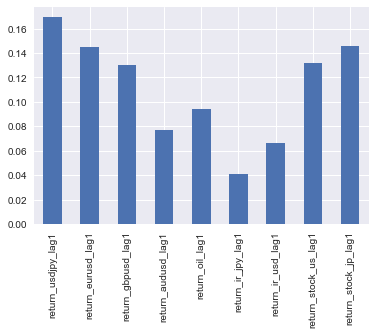

In [11]:
# Decision Tree with GridsearchCV
from sklearn import tree
from sklearn.model_selection import GridSearchCV

# 特徴量
attribute = [
    'return_usdjpy_lag1',
    'return_eurusd_lag1',
    'return_gbpusd_lag1',
    'return_audusd_lag1',
    'return_oil_lag1',
    'return_ir_jpy_lag1',
    'return_ir_usd_lag1',
    'return_stock_us_lag1',
    'return_stock_jp_lag1']

# Input
X_train = df_train_std[attribute]
X_test = df_test_std[attribute]

# Hyper parameterの候補
hyper_params = {
    'random_state': [1024], #model内部で乱数を使うときのシード
    'min_samples_split': [3, 5, 10, 15, 20], #nodeを分割するのに必要なパラメータの最小値
    'max_depth': [10, 20, 30] #Treeの深さの最大値
}

# GridSearchCVのConstructor
clf_tree = GridSearchCV(tree.DecisionTreeClassifier(),hyper_params, cv=5, verbose=False,refit=True)       
# 各Hyper parameterの組み合わせでTraing
clf_tree.fit(X_train, y_train) 

# bestなHyperParametrでのTraining結果に対する特徴量の重要度
importance = clf_tree.best_estimator_.feature_importances_
pd.Series(importance, index = X_train.columns).plot.bar()
print(clf_tree.best_params_) #bestなHyperParameterの表示

# Output: 為替予想 up(+1) down(-1)
predict_tree_train = clf_tree.best_estimator_.predict(X_train)
predict_tree_test = clf_tree.best_estimator_.predict(X_test)

pd.DataFrame({
    'Training': [metrics.accuracy_score(predict_tree_train, y_train)], #Traing dataに対する正解率
    'Test':[metrics.accuracy_score(predict_tree_test, y_test)] }, #Test dataに対する正解率
    index={'score'}) 

## 2.3.3(2) 予測モデルのTest Random Forest

### Setting
- Input/Output: 2.3.3(1)と同じ
    
### Result
- 学習データに対する正解率はDecision Treeより改善し、特徴量ごとの重要度も概ね落ち着いている。
- Testデータに対する正答率もDecision Treeより良くなっているが、まだオーバーフィッティングしている感がある。

{'max_depth': 10, 'min_samples_split': 20, 'random_state': 1024}


,Training,Test
score,0.887391,0.502609


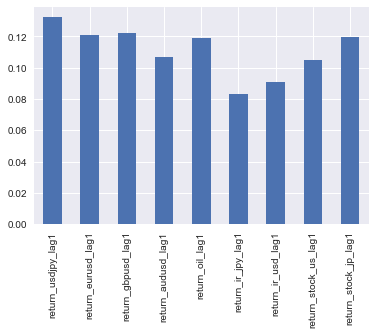

In [12]:
# Random forest with GridsearchCV
from sklearn.ensemble import RandomForestClassifier as RFC

# Hyper parameterはDecisionTreeで見つけたものを使用
hyper_params = {
    'random_state': [clf_tree.best_params_['random_state']], #内部で使われる乱数のシード
    'min_samples_split': [clf_tree.best_params_['min_samples_split']], #nodeを分割するのに必要なパラメータの最小値
    'max_depth': [clf_tree.best_params_['max_depth']] #Treeの深さの最大値
}

# GridSearchCVのConstructor
clf_rf = GridSearchCV(RFC(), hyper_params, cv=5, verbose=False, refit=True, n_jobs=-1)       
clf_rf.fit(X_train, y_train) # 各Hyper parameterの組み合わせでTraing

# bestなHyperParametrでのTraining結果に対する特徴量の重要度
importance = clf_rf.best_estimator_.feature_importances_
pd.Series(importance, index = X_train.columns).plot.bar()
print(clf_rf.best_params_) #bestなHyperParameterの表示

# Output: 為替予想 up(+1) down(-1)
predict_rf_train = clf_rf.best_estimator_.predict(X_train) 
predict_rf_test = clf_rf.best_estimator_.predict(X_test) 

pd.DataFrame({
    'Training': [metrics.accuracy_score(predict_rf_train, y_train)], #trainig dataに対する予想
    'Test':[metrics.accuracy_score(predict_rf_test, y_test)] }, #test dataに対する予想
    index={'score'})

## 2.3.4 予測モデルの例 Deep Learning
### Neural Networkを使用し、為替を予測する
- 今回は最もシンプルなNeuralNetworkである多層パーセプトロンで実験する。
- 各層$i=1,...,n$に対して、以下の線形変換と非線形変換を行う。
    - 線形変換(全結合)
         - $u^{(i)} = W^{(i)} x^{(i-1)} + W_0^{(i)},$
    - 非線形変換(activation)
        - $x^{(i)} = h(u^{(i)}).$
        
- 各種パラメータの定義        
    - $ x^{(i)} \in {\bf R}^{m_i}$: 層 $i$ におけるInput
    -  $m_i$ : 層 $i$ におけるニューロン数　
    - 入力層 $i = 0$
    - 中間層(隠れ層) $i=2,3,\dots, n-1$
    - 出力層 $i = n$
    - $h$: activation function
    - $h(x) = (1+e^{-x})^{-1}$: logistic function
    - $h(x) = max(x, 0)$: relu
    - solverにより、$W^{(i)}$を決める。


- 実際は次が使われることが多い
    - LSTM: 長期と短期記憶を持ったNeural Network. テクニカル分析のようにチャートの時系列から特徴を見つけ出す。
    - CNN: 画像認識などに用いられる手法。チャートの形状から上昇する特徴を見つけ出す。　
    

## 2.3.4 予測モデルのTest Deep Learning

### Setting
- Input/Output: 2.3.3(1)と同じ
    
### Result
- 学習データとテストデータに対する正解率は同等で、Testデータに対する正答率は今回試した手法の中では最も精度が高い。

In [13]:
# NeuralNetwork with GridsearchCV
from sklearn.neural_network import MLPClassifier

# Hyper parameterの候補
tuned_parameters =     {
    'solver':['sgd'],   # 最適化手法 stochastic gradient desent
    'activation': ['logistic', 'tanh'], # activation function
    # 隠れ層の層の数と、各層のニューロンの数
    'hidden_layer_sizes':[(50, 100, 50), (100, 50, 50),(100, 50, 100)], 
    'random_state':[1024], #内部で使われる乱数のシード
    'max_iter':[10000] # 最適化時の最大イテレーション数
}

# GridSearchCVのConstructor
clf_nn=GridSearchCV(MLPClassifier(), param_grid=tuned_parameters, scoring='accuracy', cv=5, refit=True, n_jobs=-1)
clf_nn.fit(X_train, y_train) # 各Hyper parameterの組み合わせでTraing
print(clf_nn.best_params_) #bestなHyperParameterの表示

# Output: 為替予想 up(+1) down(-1)
predict_nn_train = clf_nn.best_estimator_.predict(X_train)
predict_nn_test = clf_nn.best_estimator_.predict(X_test)

pd.DataFrame({
    'Training': [metrics.accuracy_score(predict_nn_train, y_train)], #trainig dataに対する予想
    'Test':[metrics.accuracy_score(predict_nn_test, y_test)] }, #test dataに対する予想
    index={'score'})


{'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 100), 'max_iter': 10000, 'random_state': 1024, 'solver': 'sgd'}


,Training,Test
score,0.536087,0.525217


## 2.4  取引戦略のモデル化とバックテスト
### 取引戦略のモデル化
- 為替予測が立ったら、それを元に取引戦略を考える
    - 戦略＝為替のポジション（保有量）を決めること。
    
- 時点$t_i$ での為替のポジションを$\theta_i$とする
    - USDJPY, $\theta_i=1$ の場合、1ドルの買いポジション(１ドルを持っている)
        - USDJPYレートが上がると利益が出て、下がると損失が出る
    - USDJPY, $\theta_i=-1$の場合、１ドルの売りポジション（１ドルを売っている（空売りしている））
        - USDJPYレートが下がると利益が出て、上がると損失が出る
- 時点$t_{i}$でのPL(Profit & Loss 損益)
    - $t_{i-1}$に構築したポジションを全て解消したとすると発生する損益： <span style="color: blue; ">$\theta_{i-1} X(t_{i})$</span>
    - 時点$t_{i}$に新しいポジション$\theta_i$を構築するためのコスト: <span style="color: red; ">$-\theta_i X(t_i)$</span>
    -  $PL(t_i) = \theta_i (X(t_{i+1}) - X(t_i))$
        
| 時刻 | ポジション | PL |
| :---: | :---: | :---: |
| $t_0$ | $\theta_0$ | <span style="color: red; ">$-\theta_0$ $X(t_0)$</span>|
| $t_1$ | $\theta_1$ | <span style="color: blue; ">$+ \theta_0$ $X(t_1)$</span> <br>  <span style="color: red; ">$-\theta_1$ $X(t_1)$</span> |
| $\cdots$| $\cdots$| $\cdots$ |
| $t_{n}$-1 | $\theta_{n-1}$ | <span style="color: blue; ">$+ \theta_{n-2}$ $X$$(t_{n-1}$)</span> <br>  <span style="color: red; "> -$\theta_{n-1}$ X(tn-1)</span> |
| $t_{n}$ | $\theta_{n}=0$ | <span style="color: blue; ">+$ \theta_{n-1}$ $X(t_n)$</span> |

- 期間　$t_i, i = 1,\dots, n$ のTotalの収益は
$$V(t_n) = \sum_{i=0}^{n-1} \theta_i \left(X(t_{i+1})  - X({t_i}) \right). $$

### 注意
- 上のモデル化では、現実には存在する以下の点を簡単のため省略している。
    - 買う時にはAsk Price, 売る時にはBid Priceで取引することになり、Bid Askスプレッドが存在している。
    - 取引コスト。
    - $\theta$に関する制限(ポジションリミット)がある。

### バックテスト
- 取引戦略を実行することで得られる、価値プロセス $V(t_n)$がモデル化できたので、これを過去の一定期間のデータを使って実施してみて、戦略がうまくワークするかどうかをチェックすること。


## 2.4.1 取引戦略のモデル化とバックテストの例 (SMA)

- 短気SMA($t_{i-1}$) > 長期SMA($t_{i-1}$) => 買い(ロング)ポジション　=>  $\theta_{i-1} = +1$
- 短気SMA($t_{i-1}$) < 長期SMA($t_{i-1}$) => 売り(ショート)ポジション =>  $\theta_{i-1} = -1$

データの並び方の概略

| 時刻 | fx |ポジション|$\Delta$fx (base)|
| :---: | :---: | :---: | :---: |
|$t_i$ | fx($t_i$) | $\theta_{i-1}$ |fx($t_i$) $-$ fx($t_{i-1}$)|

<AxesSubplot:xlabel='DATE'>

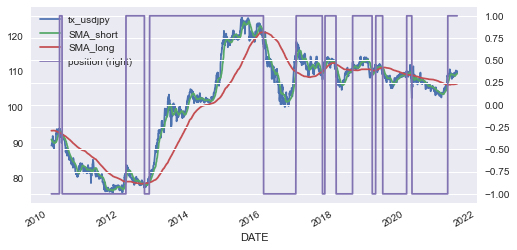

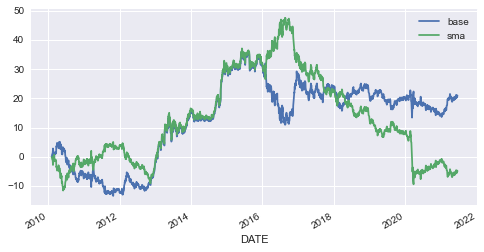

In [14]:
#SMAの期間
sma_short = 25
sma_long = 250

#移動平均をとる
data = pd.DataFrame({
    'fx_usdjpy': df['fx_usdjpy'],
    'SMA_short': df['fx_usdjpy'].rolling(sma_short).mean(),
    'SMA_long': df['fx_usdjpy'].rolling(sma_long).mean()
    
})
data.dropna(inplace=True)

# position は一日前のSMAの大小関係で決める (position=\theta_{i-1})
data['position'] = np.where(data['SMA_short'].shift(1) > data['SMA_long'].shift(1) , 1, -1)
data.plot(secondary_y='position', figsize=(8,4))

# baseは単純に為替を１単位持っていたときのPL (fx(t_i)-fx(t_{i-1}))
data['base'] = df['fx_usdjpy'].diff() 
# sma PL は \theta_{i-1} * (fx(t_i)-fx(t_{i-1}))
data['sma'] = data['position'] * data['base']

#t_i までのそれぞれのtotal PL
data[['base', 'sma']].cumsum().plot(figsize=(8, 4))

## 2.4.2 取引戦略のモデル化とバックテストの例 (2.3の為替予測に基づく戦略)
2.3で構築したそれぞれの為替予測モデル ($u_i$) を使って、以下のようにポジションを決める。
- $\theta_{i-1} = u_{i}$とする ($u_i$は$t_{i-1}$までの特徴量から予測した$t_i$時点の為替の上下予想)。すなわち
    - 時刻 $t_{i-1}$に $t_{i}$の為替が上がると予測 ($u_{i}=+1$) $\Rightarrow$ $t_{i-1}$における買い(ロング)ポジション($\theta_{i-1} = +1$)
    - 時刻 $t_{i-1}$に $t_{i}$の為替が下がると予測 ($u_{i}=-1$) $\Rightarrow$ $t_{i-1}$における売り(ショート)ポジション($\theta_{i-1} = -1$)

データの並び方の概略

| 時刻 | fx |Position|$\Delta$fx (base)|Predict|
| :---: | :---: | :---: | :---: | :---: |
|$t_i$ | fx($t_i$) | $\theta_{i-1}$ |fx($t_i$) $-$ fx($t_{i-1}$)|$u_{i}$ |

### Result
- 各StrategyのPLのパフォーマンスは、2.3の為替予想のtestデータに対する正解率の順に並んでいる。
    - (NN > Lasso > rf > tree > regression2 > base > regression )

<AxesSubplot:xlabel='DATE'>

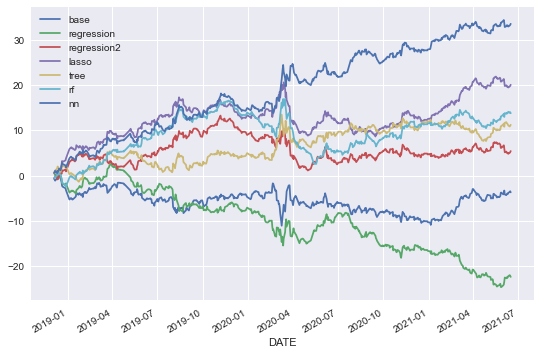

In [15]:
# (fx(t_i)-fx(t_{i-1}))のデータをTrainingとTest 期間に分ける(Traing用は使わないが)
dX0, dX = train_test_split(df['fx_usdjpy'].diff(), test_size=0.2, shuffle=False)
pl = pd.DataFrame({'base': dX})

# PL = \theta_{i-1} * (fx(t_i)-fx(t_{i-1})), \theta_{i-1}=predict_{i}
pl['regression'] = predict_regression_test * dX
pl['regression2'] = predict_regression2_test * dX
pl['lasso'] = predict_lasso_test * dX
pl['tree'] = predict_tree_test * dX
pl['rf'] = predict_rf_test * dX
pl['nn'] = predict_nn_test * dX

# PL = sum PL
np.cumsum(pl).plot(figsize=(9, 6))

# 課題
1.  為替相場(もしくは他アセット)を予測する上で、あなたはどんな特徴量やモデルがいいと思いますか？もしくは本講義で用いた特徴量やモデルに対してどのような改善点が考えられますか？理由と共に教えてください。
2.  (任意*) 1で考えた特徴量とモデルを本講義で用いたコードを参考に実装し、どのようなパフォーマンスが出るか実験してみてください。

 
*２はpythonの環境の問題で本シートが動かないなどの問題があるかもしれないので、レポート評価の対象ではないですが、興味がある人はぜひ自分で手を動かして実験してみてください。